# ELEC4010 fianl project
# Semi-supervised classification
### HUANG, Jiajun(20694015)

# Download the data

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

--2023-05-21 08:01:20--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.129.225, 52.217.10.164, 52.216.113.59, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.129.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part3_Training_Data.zip’

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  75.6MB/s    in 7.9s    

2023-05-21 08:01:28 (76.7 MB/s) - ‘ISBI2016_ISIC_Part3_Training_Data.zip’ saved [631625308/631625308]

--2023-05-21 08:01:28--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.29.237, 54.231.138.129, 52.217.201.177, ...
Connecting to isic-challenge-data.s3.amazonaws.com (

# Splitting the data randomly

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from torch.utils.data import random_split

if not os.path.exists("./train_sup"):
    os.makedirs("./train_sup")
    os.makedirs("./train_sup/benign")
    os.makedirs("./train_sup/malignant")
if not os.path.exists("./train_unsup"):
    os.makedirs("./train_unsup")
    os.makedirs("./train_unsup/benign")
    os.makedirs("./train_unsup/malignant")
if not os.path.exists("./val"):
    os.makedirs("./val")
    os.makedirs("./val/benign")
    os.makedirs("./val/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)
N_train_val = len(img_lis)
N_train_sup = int(N_train_val * 0.3) # labelled training set
N_train_unsup = int(N_train_val * 0.6) # unlabelled training set
N_val = N_train_val - N_train_sup - N_train_unsup
print('Total number of images: ' + str(N_train_val))
print('Number of labelled training set: ' + str(N_train_sup))
print('Number of labelled training set: ' + str(N_train_unsup))
print('Number of validation set: ' + str(N_val))
shuffle_ix = np.random.permutation(np.arange(N_train_val))
#ix_train_sup = shuffle_ix[:N_train_sup]
#ix_train_unsup = shuffle_ix[N_train_sup:N_train_sup+N_train_unsup]
#ix_val = shuffle_ix[N_train_sup+N_train_unsup:]
ix_train_sup, ix_train_unsup, ix_val = random_split(shuffle_ix, [0.3, 0.6, 0.1])
print(len(shuffle_ix))
print(len(ix_train_sup))
print(len(ix_train_unsup))
print(len(ix_val))
for i in ix_train_sup:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train_sup/"+label+"/"+name+".jpg")
for i in ix_train_unsup:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train_unsup/"+label+"/"+name+".jpg")
for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")

if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

Total number of images: 900
Number of labelled training set: 270
Number of labelled training set: 540
Number of validation set: 90
900
270
540
90


# Dataloaders

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

root_train_sup = './train_sup'
root_train_unsup = './train_unsup'
train_transform = transforms.Compose([
    transforms.Resize(244),
    #transforms.RandomVerticalFlip(),       # using stronger augmentation functions to enhance performance or solve LT problem
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_val = './val'
root_test = './test'
test_transform = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set(batch_size=12):
    sup_train_dataset = ImageFolder(root_train_sup, transform=train_transform)
    loader_train_sup = torch.utils.data.DataLoader(
        dataset=sup_train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    unsup_train_dataset = ImageFolder(root_train_unsup, transform=train_transform)
    loader_train_unsup = torch.utils.data.DataLoader(
        dataset=unsup_train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )
    return loader_train_sup, loader_train_unsup, loader_val, loader_test
batch_size = 12
loader_train_sup, loader_train_unsup, loader_val, loader_test = get_train_test_set(batch_size)
# image: torch.Size([12, 3, 224, 224])

# Model

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50
class Model(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(Model, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
resnet50 = get_resnet50(pre_trained=True)

base_model = Model(resnet50, 1)
model1 = Model(resnet50, 1)
model2 = Model(resnet50, 1)
# output: torch.Size([12, 1])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


# Baseline training and validation

In [ ]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

max_epoch = 10
use_cuda = True
if use_cuda:
    base_model = base_model.cuda()
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.6, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        alpha = self.alpha
        gamma = self.gamma
        loss = - alpha * (1 - logits) ** gamma * target * torch.log(logits) - \
               (1 - alpha) * logits ** gamma * (1 - target) * torch.log(1 - logits)
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

cps_criterion = nn.BCELoss()
criterion = BCEFocalLoss()
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9)


loss_list = []
auc_train_list = []
auc_val_list = []
acc_train_list = []
acc_val_list = []
for epoch in range(max_epoch):
    train_lbl, train_pred = [], []
    running_loss = 0.0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))
    base_model.train()
    for data in tqdm(loader_train_sup):
        optimizer.zero_grad()
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = base_model(images)[:,0]
        outputs = F.sigmoid(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    loss = running_loss / len(loader_train_sup)
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)


    # evaluate on validation set
    base_model.eval()
    val_lbl, val_pred = [], []
    for data in loader_val:
        val_images, val_labels = data
        if use_cuda:
            val_images = val_images.cuda()
            val_labels = val_labels.float().cuda()
        val_outputs = base_model(val_images)[:, 0]
        val_outputs = F.sigmoid(val_outputs)
        y_scores = list(val_outputs.detach().cpu().numpy())
        y_true = list(val_labels.detach().cpu().numpy())
        val_lbl += y_true
        val_pred += y_scores

    val_lbl, val_pred = np.array(val_lbl), np.array(val_pred)
    val_pred_lbl = np.around(val_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    val_auc = roc_auc_score(val_lbl, val_pred)
    val_acc = accuracy_score(val_lbl, val_pred_lbl)
    auc_val_list.append(val_auc)
    acc_val_list.append(val_acc)

    print("Loss {:.4f}, Training AUC {:.4f}, Validation AUC {:.4f}".format(
        loss,
        train_auc,
        val_auc
    ))

 -- Epoch 1/10


100%|██████████| 23/23 [00:22<00:00,  1.04it/s]


Loss 0.0687, Training AUC 0.5275, Validation AUC 0.5479
 -- Epoch 2/10


100%|██████████| 23/23 [00:18<00:00,  1.22it/s]


Loss 0.0556, Training AUC 0.7829, Validation AUC 0.6682
 -- Epoch 3/10


100%|██████████| 23/23 [00:19<00:00,  1.21it/s]


Loss 0.0493, Training AUC 0.8357, Validation AUC 0.6100
 -- Epoch 4/10


100%|██████████| 23/23 [00:18<00:00,  1.22it/s]


Loss 0.0427, Training AUC 0.9027, Validation AUC 0.7256
 -- Epoch 5/10


100%|██████████| 23/23 [00:18<00:00,  1.23it/s]


Loss 0.0420, Training AUC 0.8997, Validation AUC 0.7726
 -- Epoch 6/10


100%|██████████| 23/23 [00:18<00:00,  1.22it/s]


Loss 0.0410, Training AUC 0.9157, Validation AUC 0.7199
 -- Epoch 7/10


100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


Loss 0.0313, Training AUC 0.9601, Validation AUC 0.6485
 -- Epoch 8/10


100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


Loss 0.0298, Training AUC 0.9539, Validation AUC 0.7171
 -- Epoch 9/10


100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


Loss 0.0286, Training AUC 0.9539, Validation AUC 0.6786
 -- Epoch 10/10


100%|██████████| 23/23 [00:19<00:00,  1.18it/s]


Loss 0.0222, Training AUC 0.9802, Validation AUC 0.6992


# Baseline testing

In [ ]:
base_model.eval()
test_lbl, test_pred = [], []
for data in loader_test:
    test_images, test_labels = data
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = base_model(test_images)[:, 0]
    test_outputs = F.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores

test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)

print("Testing AUC {:.4f}, Testing accuracy {:.4f}%".format(
    test_auc,
    test_acc * 100
))

Testing AUC 0.7790, Testing accuracy 80.7388%


Text(0.5, 1.0, 'Validation accuracy')

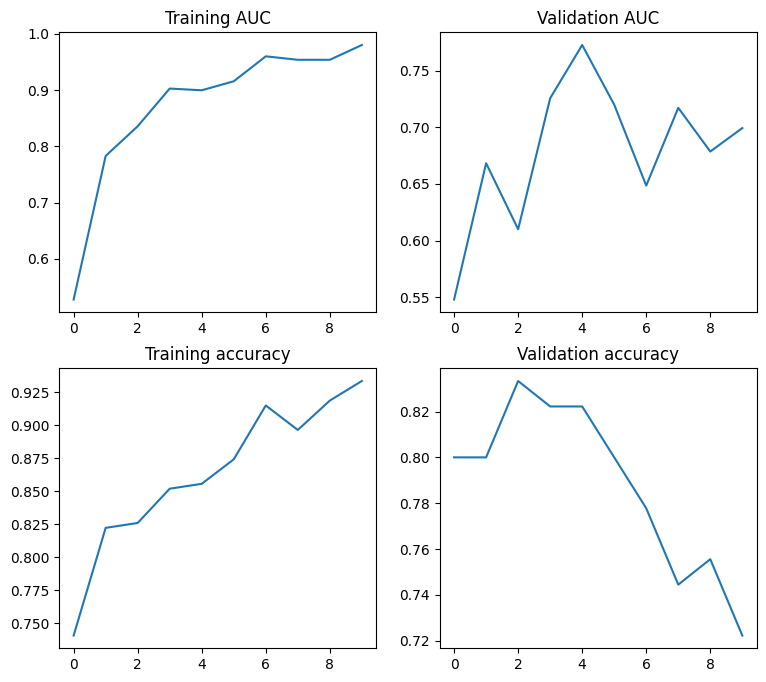

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,8))
plt.subplot(2,2,1)
plt.plot(auc_train_list)
plt.title("Training AUC")
plt.subplot(2,2,2)
plt.plot(auc_val_list)
plt.title("Validation AUC")
plt.subplot(2,2,3)
plt.plot(acc_train_list)
plt.title("Training accuracy")
plt.subplot(2,2,4)
plt.plot(acc_val_list)
plt.title("Validation accuracy")

Text(0.5, 1.0, 'Training Loss')

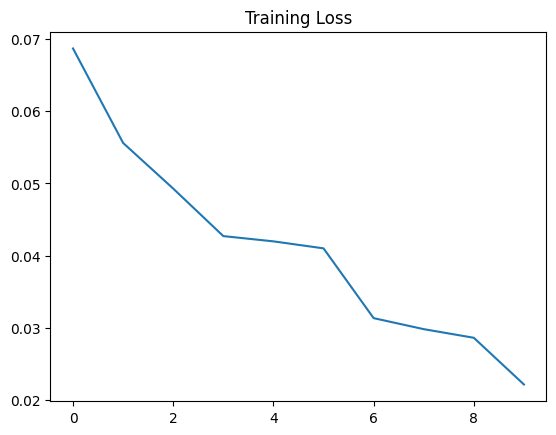

In [ ]:
plt.plot(loss_list)
plt.title("Training Loss")

# Training and validation for model trained with cross pseudo supervision(CPS)

In [ ]:
from itertools import cycle

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
if use_cuda:
    model1 = model1.cuda()
    model2 = model2.cuda()

loss_list = []
auc1_val_list = []
acc1_val_list = []
auc2_val_list = []
acc2_val_list = []
for epoch in range(max_epoch):
    running_loss = 0.0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))
    model1.train()
    model2.train()
    for data_sup, data_unsup in tqdm(zip(cycle(loader_train_sup), loader_train_unsup)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        images_sup, labels_sup = data_sup
        images_unsup, _ = data_unsup
        if use_cuda:
            images_sup = images_sup.cuda()
            labels_sup = labels_sup.float().cuda()
            images_unsup = images_unsup.cuda()


        pred_sup_1 = model1(images_sup)[:,0]
        pred_sup_1 = F.sigmoid(pred_sup_1)

        pred_sup_2 = model2(images_sup)[:,0]
        pred_sup_2 = F.sigmoid(pred_sup_2)

        pred_unsup_1 = model1(images_unsup)[:,0]
        pred_unsup_1 = F.sigmoid(pred_unsup_1)

        pred_unsup_2 = model2(images_unsup)[:,0]
        pred_unsup_2 = F.sigmoid(pred_unsup_2)

        pred_1 = torch.cat([pred_sup_1, pred_unsup_1], dim=0)
        pred_2 = torch.cat([pred_sup_2, pred_unsup_2], dim=0)

        pseudo_label_1 = torch.round(pred_1)
        pseudo_label_2 = torch.round(pred_2)

        cps_loss = criterion(pred_1, pseudo_label_2) + criterion(pred_2, pseudo_label_1)
        loss_sup_1 = criterion(pred_sup_1, labels_sup)
        loss_sup_2 = criterion(pred_sup_2, labels_sup)
        loss = cps_loss + loss_sup_1 + loss_sup_2

        loss.backward()
        optimizer1.step()
        optimizer2.step()

        running_loss += loss.item()

    loss = running_loss / len(loader_train_unsup)
    loss_list.append(loss)

    model1.eval()
    model2.eval()
    val_lbl1, val_pred1 = [], []
    val_lbl2, val_pred2 = [], []
    for data in loader_val:
        val_images, val_labels = data
        if use_cuda:
            val_images = val_images.cuda()
            val_labels = val_labels.float().cuda()

        val_outputs1 = model1(val_images)[:, 0]
        val_outputs1 = F.sigmoid(val_outputs1)
        val_outputs2 = model2(val_images)[:, 0]
        val_outputs2 = F.sigmoid(val_outputs2)

        y_scores1 = list(val_outputs1.detach().cpu().numpy())
        y_true1 = list(val_labels.detach().cpu().numpy())
        val_lbl1 += y_true1
        val_pred1 += y_scores1

        y_scores2 = list(val_outputs2.detach().cpu().numpy())
        y_true2 = list(val_labels.detach().cpu().numpy())
        val_lbl2 += y_true2
        val_pred2 += y_scores2

    val_lbl1, val_pred1 = np.array(val_lbl1), np.array(val_pred1)
    val_lbl2, val_pred2 = np.array(val_lbl2), np.array(val_pred2)

    val_pred_lbl1 = np.around(val_pred1) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    val_pred_lbl2 = np.around(val_pred2)

    val_auc1 = roc_auc_score(val_lbl1, val_pred1)
    val_acc1 = accuracy_score(val_lbl1, val_pred_lbl1)
    val_auc2 = roc_auc_score(val_lbl2, val_pred2)
    val_acc2 = accuracy_score(val_lbl2, val_pred_lbl2)

    auc1_val_list.append(val_auc1)
    acc1_val_list.append(val_acc1)
    auc2_val_list.append(val_auc2)
    acc2_val_list.append(val_acc2)

    print("Loss {:.4f}, Validation AUC1 {:.4f}, Validation AUC2 {:.4f}".format(
        loss,
        val_auc1,
        val_auc2
    ))


 -- Epoch 1/10


45it [01:10,  1.57s/it]


Loss 0.3248, Validation AUC1 0.6870, Validation AUC2 0.7509
 -- Epoch 2/10


45it [01:10,  1.58s/it]


Loss 0.2763, Validation AUC1 0.6917, Validation AUC2 0.7688
 -- Epoch 3/10


45it [01:09,  1.55s/it]


Loss 0.1268, Validation AUC1 0.7171, Validation AUC2 0.7519
 -- Epoch 4/10


45it [01:09,  1.55s/it]


Loss 0.0751, Validation AUC1 0.7622, Validation AUC2 0.7763
 -- Epoch 5/10


45it [01:08,  1.53s/it]


Loss 0.0644, Validation AUC1 0.7782, Validation AUC2 0.7951
 -- Epoch 6/10


45it [01:09,  1.54s/it]


Loss 0.0514, Validation AUC1 0.7641, Validation AUC2 0.7820
 -- Epoch 7/10


45it [01:10,  1.58s/it]


Loss 0.0337, Validation AUC1 0.7434, Validation AUC2 0.7575
 -- Epoch 8/10


45it [01:09,  1.54s/it]


Loss 0.0339, Validation AUC1 0.7425, Validation AUC2 0.7632
 -- Epoch 9/10


45it [01:11,  1.59s/it]


Loss 0.0301, Validation AUC1 0.7829, Validation AUC2 0.7857
 -- Epoch 10/10


45it [01:09,  1.55s/it]


Loss 0.0243, Validation AUC1 0.7726, Validation AUC2 0.7923


# Testing for model trained with CPS

In [ ]:
model1.eval()
model2.eval()
test_lbl1, test_pred1 = [], []
test_lbl2, test_pred2 = [], []
for data in loader_test:
    test_images, test_labels = data
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()

    test_outputs1 = model1(test_images)[:, 0]
    test_outputs1 = F.sigmoid(test_outputs1)
    test_outputs2 = model2(test_images)[:, 0]
    test_outputs2 = F.sigmoid(test_outputs2)

    y_scores1 = list(test_outputs1.detach().cpu().numpy())
    y_true1 = list(test_labels.detach().cpu().numpy())
    test_lbl1 += y_true1
    test_pred1 += y_scores1

    y_scores2 = list(test_outputs2.detach().cpu().numpy())
    y_true2 = list(test_labels.detach().cpu().numpy())
    test_lbl2 += y_true2
    test_pred2 += y_scores2

test_lbl1, test_pred1 = np.array(test_lbl1), np.array(test_pred1)
test_lbl2, test_pred2 = np.array(test_lbl2), np.array(test_pred2)

test_pred_lbl1 = np.around(test_pred1) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_pred_lbl2 = np.around(test_pred2)

test_auc1 = roc_auc_score(test_lbl1, test_pred1)
test_acc1 = accuracy_score(test_lbl1, test_pred_lbl1)
test_auc2 = roc_auc_score(test_lbl2, test_pred2)
test_acc2 = accuracy_score(test_lbl2, test_pred_lbl2)

print("Testing AUC1 {:.4f}, Testing accuracy1 {:.4f}%".format(
    test_auc1,
    test_acc1 * 100
))

print("Testing AUC2 {:.4f}, Testing accuracy2 {:.4f}%".format(
    test_auc2,
    test_acc2 * 100
))

Testing AUC1 0.7835, Testing accuracy1 81.2665%
Testing AUC2 0.7675, Testing accuracy2 81.7942%


Text(0.5, 1.0, 'Validation accuracy2')

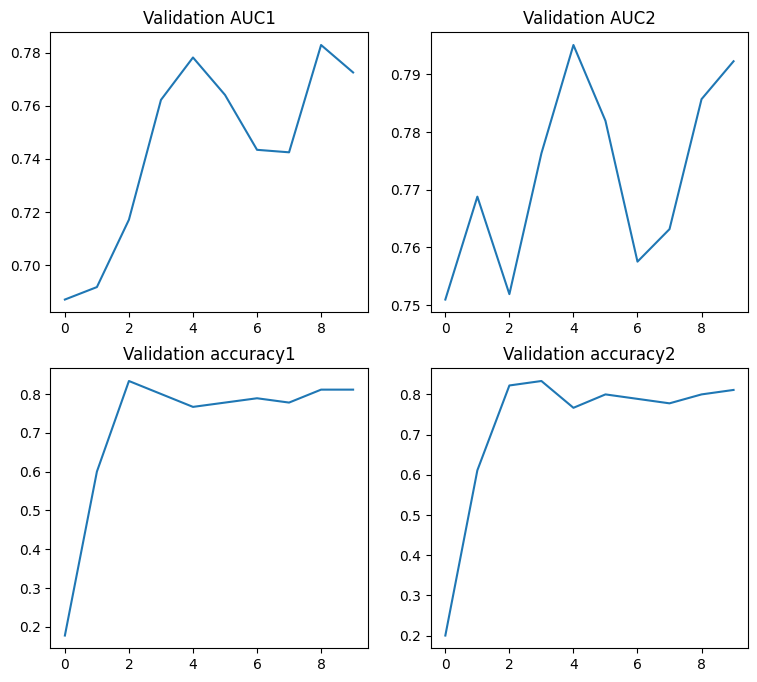

In [ ]:
plt.figure(figsize=(9,8))
plt.subplot(2,2,1)
plt.plot(auc1_val_list)
plt.title("Validation AUC1")
plt.subplot(2,2,2)
plt.plot(auc2_val_list)
plt.title("Validation AUC2")
plt.subplot(2,2,3)
plt.plot(acc1_val_list)
plt.title("Validation accuracy1")
plt.subplot(2,2,4)
plt.plot(acc2_val_list)
plt.title("Validation accuracy2")

Text(0.5, 1.0, 'Training Loss')

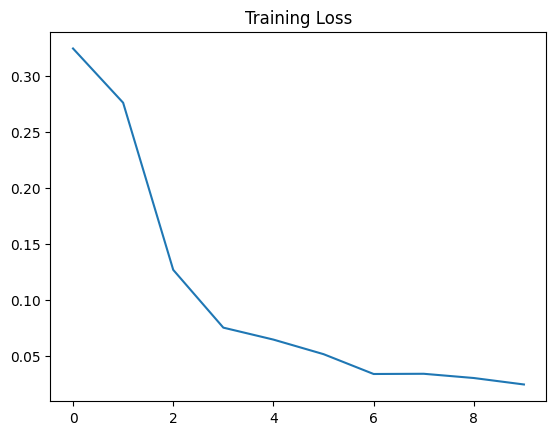

In [ ]:
plt.plot(loss_list)
plt.title("Training Loss")